In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from simulator_wrapper import run_simulator_day
from reinforcement_learning.agent import Agent
from reinforcement_learning.environment import Environment
from reinforcement_learning.experience_buffer import ExperienceBuffer
from reinforcement_learning.policy import ContinuousRandomPolicy, TransformContinuousActions
from utils import extract_patient_meal_carbs, extract_patient_meal_times

In [4]:
NO_ACTION = np.zeros((2,3))
df = pd.read_csv('subject_profiles.csv')

def plot_simulator(day:int=0, BM=NO_ACTION):
    patient_data = df.iloc[day]
    meal_times = extract_patient_meal_times(patient_data)
    meal_carbs = extract_patient_meal_carbs(patient_data)
    assert len(meal_carbs) == len(meal_times), "Number of carb intakes and number of meals must be identical."
    time, glucose, score = run_simulator_day(day, BM)
    plt.plot(time, glucose, '--k')
    plt.vlines(meal_times, 0, 1000, 'r')
    plt.vlines(meal_times, 0, meal_carbs, 'k')
    plt.vlines(BM[0], 0, 1000, 'b')
    plt.hlines([70, 180], 0, 1440, 'g', alpha=0.5)
    plt.xlim(0, 1440)
    plt.ylim(0, 1000)
    print(r'With score: %f3'%(score))

## Performance of continuous random policy

With score: 34.8611113


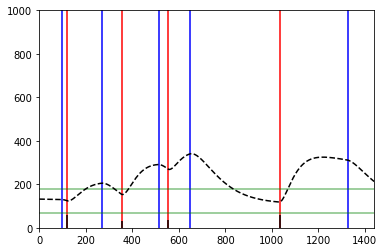

In [5]:
random_policy = ContinuousRandomPolicy()
i = 12
patient_data = df.iloc[i]
env = Environment(patient_data)
raw_actions = random_policy.act_episode(num_steps=env.num_meals + 1)
random_BM = TransformContinuousActions().forward(
    raw_actions=raw_actions, 
    time_stamps=env.time_stamps,
    dose_range=env.dose_range
)
plot_simulator(day=i, BM=random_BM)

In [6]:
experience_buffer = ExperienceBuffer(
    max_memory_size= 500, 
    env_id_list=[12], 
    shape_dict=dict(
        states=(1, np.float32),
        next_states=(1, np.float32),
        raw_actions=(2, np.float32),
        BM=(2, np.float32),
        rewards=(1, np.float32),
        interval_size=(1, np.float32),
        carbs=(1, np.float32),
        termination_masks=(1, 'uint8')
    )
)
agent = Agent(exploratory_policy=random_policy,
              learnt_policy=random_policy,
              global_buffer=experience_buffer, 
              fictional_buffer=experience_buffer)